## Conv2d

反复运行多次，观察卷积核卷积后的结果，也可调整 Conv2d 参数观察输出特征图变化。


In [ ]:
# 图像 Tensor 还原回 PIL 图像
def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    # 逆归一化
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(
            x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(
            norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(
            norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])
    # yTorch 处理的图像张量格式为 [C, H, W]，但 PIL.Image 需要 [H, W, C]。
    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    # 逆 ToTensor 变换
    if 'ToTensor' in str(transform_train) or img_.max() < 1:
        img_ = img_.detach().numpy() * 255
    # 转换为 PIL.Image
    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception(
            "Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]))

    return img_

卷积前尺寸:torch.Size([1, 3, 4095, 3342])
卷积后尺寸:torch.Size([1, 1, 4093, 3340])


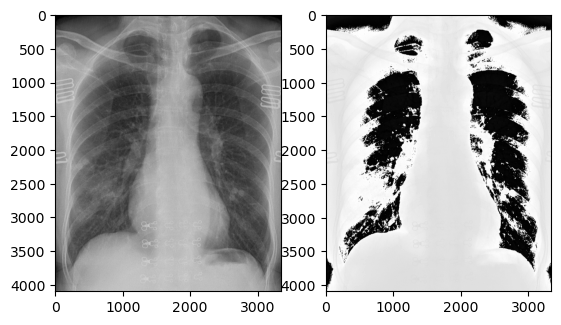

In [ ]:
import os
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
# load img
#  "..", ".."访问上级的上级目录
path_img = os.path.join(os.getcwd(),
                        "..", "..", "data", "datasets", "covid-19-demo", "imgs", "covid-19", "ryct.2020200028.fig1a.jpeg")
img = Image.open(path_img).convert('RGB')  # 0~255
img_transform = transforms.Compose(
    [transforms.ToTensor()])  # convert to tensor
img_tensor = img_transform(img)
# img_tensor.unsqueeze_(dim=0) 给张量添加一个额外的维度，变成 [B, C, H, W] 形式，其中 B 是批量大小（这里是1），C 是通道数（RGB图像为3），H 和 W 是高度和宽度
img_tensor.unsqueeze_(dim=0)    # C*H*W to B*C*H*W
# define layer
# in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1
# input:(i, o, size) weights:(o, i , h, w)
# 3：输入通道数，表示输入图像是RGB（3个通道）。
# 1：输出通道数，表示输出是单通道（比如灰度图）。
# 3：卷积核的大小为3x3。
# stride=1：卷积的步长为1。
# padding=0：没有使用零填充。
# dilation=1：卷积核的扩张率为1
# dilation（扩张率/膨胀率） 决定了卷积核内部元素的间隔大小，让卷积核看起来“拉伸”了，从而能覆盖更大的感受野（receptive field），不增加参数数量的情况下看到更大范围的输入特征。
conv_layer = nn.Conv2d(3, 1, 3, stride=1, padding=0, dilation=1)
# nn.init.xavier_normal_(conv_layer.weight.data)
# forward
img_conv = conv_layer(img_tensor)
# plot
print("卷积前尺寸:{}\n卷积后尺寸:{}".format(img_tensor.shape, img_conv.shape))
# img_conv[0, 0:1, ...] 取卷积输出的第一个图像（如果批量大于1）
# 0：表示选择批量中的第一个图像。0 是批量大小维度 B 的索引，意味着取第一个图像。如果批量大小 B 大于1，0 表示选取第一个样本。
# 0:1：表示选择图像的第一个通道。0:1 是切片操作，表示选择第一个通道（假设 C 是通道数）。这里的 0:1 选取了从索引 0 到 1 之间的通道，但并不包含 1，因此它实际上返回的是一个形状为 (1, H, W) 的张量，也就是选择第一个通道并保持维度。
img_conv = transform_invert(img_conv[0, 0:1, ...], img_transform)
# 去除多余的维度，恢复为2D图像
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
# 122 表示将图形分成 1 行 2 列，选中第 2 个位置（右侧）。
# 121 表示将图形分成 1 行 2 列，选中第 1 个位置（左侧）。
# 单通道图像默认使用灰度显示，所以为了确保显示灰度图像，可以显式地指定 cmap='gray'。
# 如果不指定 cmap='gray'，imshow 仍然会默认以灰度模式显示，但为了保证一致性和清晰性，显式地指定灰度色图可以更明确地告诉 matplotlib 处理方式。
plt.subplot(122).imshow(img_conv, cmap='gray')
plt.subplot(121).imshow(img_raw)
plt.show()

## pooling

尝试修改, kernel_size, stride, padding, dilation, ceil_mode 等参数，观察前后差异


### maxpool


池化前尺寸:torch.Size([1, 3, 4095, 3342])
池化后尺寸:torch.Size([1, 3, 2047, 1671])


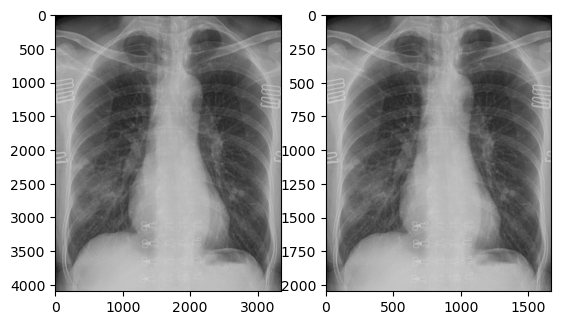

In [3]:
# kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False
# return_indices=False：
# 当 return_indices 为 True 时，最大池化操作除了返回池化后的特征图，还会返回每个最大值在原输入特征图中的索引位置，这些索引可以在后续的上采样操作（如 nn.MaxUnpool2d）中使用。设置为 False 时，仅返回池化后的特征图。
# ceil_mode=False：
# 若 ceil_mode 为 True，在计算输出特征图的尺寸时，会采用向上取整的方式；若为 False，则采用向下取整的方式。通常在池化窗口不能完全覆盖输入特征图边缘时，该参数会发挥作用。
maxpool_layer = nn.MaxPool2d((2, 2), stride=(
    2, 2), return_indices=False, ceil_mode=False)
img_pool = maxpool_layer(img_tensor)
print("池化前尺寸:{}\n池化后尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()

### MaxUnpool2d


原图尺寸:torch.Size([1, 3, 4095, 3342])
池化后尺寸:torch.Size([1, 3, 2047, 1671])
反池化后尺寸:torch.Size([1, 3, 4094, 3342])


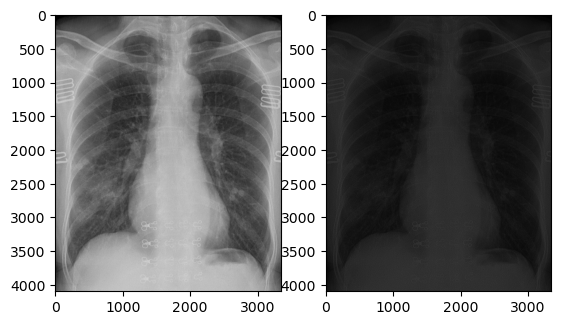

torch.Size([1, 3, 2047, 1671])
tensor([[[[       0,        2,        4,  ...,     3336,     3338,     3340],
          [    6684,    10028,    10031,  ...,    13362,    13364,    10024],
          [   13368,    13371,    16715,  ...,    16704,    16706,    20050],
          ...,
          [13665438, 13665440, 13665442,  ..., 13665432, 13665434, 13665437],
          [13668780, 13668782, 13672126,  ..., 13672117, 13672118, 13672121],
          [13675464, 13678808, 13678810,  ..., 13678801, 13678802, 13678805]],

         [[       0,        2,        4,  ...,     3336,     3338,     3340],
          [    6684,    10028,    10031,  ...,    13362,    13364,    10024],
          [   13368,    13371,    16715,  ...,    16704,    16706,    20050],
          ...,
          [13665438, 13665440, 13665442,  ..., 13665432, 13665434, 13665437],
          [13668780, 13668782, 13672126,  ..., 13672117, 13672118, 13672121],
          [13675464, 13678808, 13678810,  ..., 13678801, 13678802, 13678805]],


In [8]:
# kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False
# 对 img_tensor 进行最大池化（即取局部 2×2 领域的最大值），并返回：
# img_pool: 池化后的图像张量（尺寸减小）
# indices: 最大值的位置索引（用于反池化）
# 步长 (2, 2) 表示池化窗口在 高度（H）和宽度（W）方向 都 移动 2 像素，即：
# 第一个 2（纵向） → 在 高度方向（向下）移动 2 像素。
# 第二个 2（横向） → 在 宽度方向（向右）移动 2 像素。
maxpool_layer = nn.MaxPool2d((2, 2), stride=(
    2, 2), return_indices=True, ceil_mode=False)
img_pool, indices = maxpool_layer(img_tensor)
# MaxUnpool2d
# 最大反池化层，用于对最大池化后的特征图进行反池化操作。
# PyTorch 允许直接传递单个整数 2，它会自动转换为 (2,2)
maxunpool_layer = nn.MaxUnpool2d(2, stride=2)
img_pool_unpool = maxunpool_layer(img_pool, indices)
print("原图尺寸:{}\n池化后尺寸:{}\n反池化后尺寸:{}".format(
    img_tensor.shape, img_pool.shape, img_pool_unpool.shape))
# img_pool_unpool[0, 0:3, ...] 选择 第一张图像的前三通道 进行反变换。
img_pool_unpool = transform_invert(img_pool_unpool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool_unpool)
plt.subplot(121).imshow(img_raw)
plt.show()
print(indices.shape)
print(indices)

## AdaptiveMaxPool2d

尝试多次修改输入数据的 size，再观察池化后的 size


原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 1024, 1024])


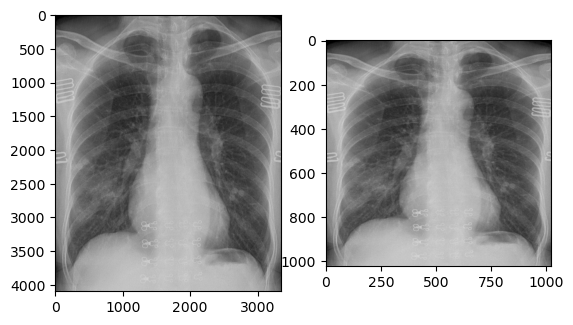

In [12]:
# 不管 img_tensor 的原始尺寸是多少，最终都会调整到 1024×1024。
ada_maxpool_layer = nn.AdaptiveMaxPool2d((1024, 1024))
img_pool = ada_maxpool_layer(img_tensor)

print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()

## ReflectionPad2d

镜像填充


原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 5119, 4366])


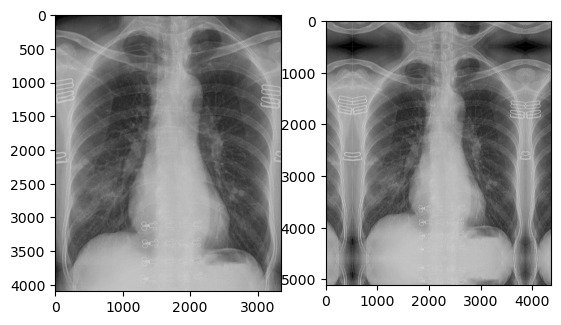

In [13]:
# 对图像四周进行 反射填充（边界镜像扩展）。
# 参数：padding=512，表示：
# 左/右/上/下 各 填充 512 像素
pad2d = nn.ReflectionPad2d(512)
img_pool = pad2d(img_tensor)
print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()

## ReplicationPad2d

边界重复值填充


原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 5119, 4366])


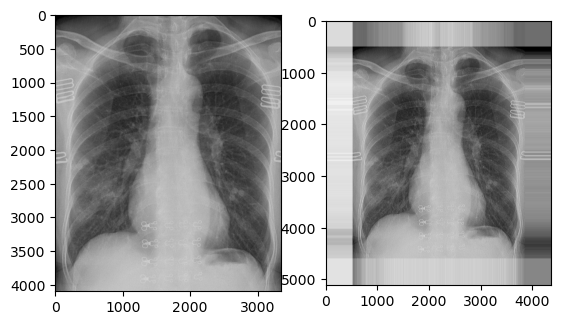

In [14]:
pad2d = nn.ReplicationPad2d(512)
img_pool = pad2d(img_tensor)
print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()

## ZeroPad2d

零值填充


原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 5119, 4366])


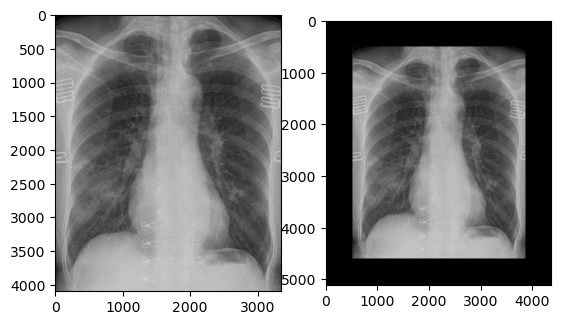

In [ ]:
# 在图像四周填充 0（黑色像素）
pad2d = nn.ZeroPad2d(512)
img_pool = pad2d(img_tensor)
print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()

## ConstantPad2d

指定值填充


原图尺寸:torch.Size([1, 3, 4095, 3342])
池化前尺寸:torch.Size([1, 3, 5119, 4366])


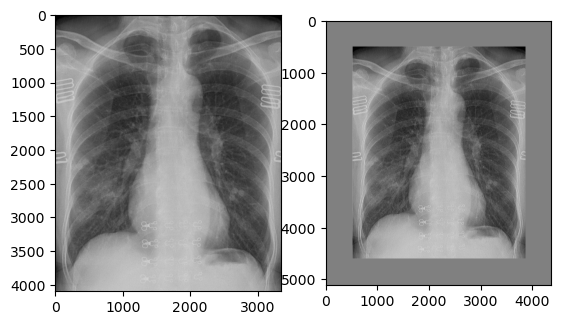

In [ ]:
# 在图像四周填充指定的常数值（这里是 128）
pad2d = nn.ConstantPad2d(512, 128)
img_pool = pad2d(img_tensor)
print("原图尺寸:{}\n池化前尺寸:{}".format(img_tensor.shape, img_pool.shape))
img_pool = transform_invert(img_pool[0, 0:3, ...], img_transform)
img_raw = transform_invert(img_tensor.squeeze(), img_transform)
plt.subplot(122).imshow(img_pool)
plt.subplot(121).imshow(img_raw)
plt.show()

## BatchNorm 2d

- 观察 BN 层四个参数的 shape，与什么有关
- 观察 BN 层输出为什么是 0？提示：参照[公式](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)计算


In [26]:
import torch
batch_size = 3
num_features = 6
momentum = 0.3
features_shape = (2, 2)
# 2D
# feature_map：生成一个大小为 2x2 的全为 1 的张量。
# feature_maps：通过堆叠多个张量，生成一个大小为 (num_features, 2, 2) 的张量，每个特征图的值逐渐增加。
# feature_maps_bs：将多个 feature_maps 栈起来，形成一个形状为 (batch_size, num_features, height, width) 的 4D 张量，即 [3, 6, 2, 2]。
feature_map = torch.ones(features_shape)
feature_maps = torch.stack([feature_map*(i+1)
                           for i in range(num_features)], dim=0)         # 3D
feature_maps_bs = torch.stack(
    [feature_maps for i in range(batch_size)], dim=0)             # 4D
# print("input data:\n{} shape is {}".format(
# feature_maps_bs, feature_maps_bs.shape))
# 用于 2D 卷积神经网络的批量归一化。它将对输入的 4D 张量进行归一化操作。
# num_features=num_features：表示输入特征图的通道数（这里是 6）。
# momentum=0.3：控制计算均值和方差的滑动平均
bn = nn.BatchNorm2d(num_features=num_features, momentum=momentum)
# running_mean, running_var = 0, 1
for i in range(2):
    outputs = bn(feature_maps_bs)
    print("\niter:{}, running_mean.shape: {}".format(i, bn.running_mean.shape))
    print("iter:{}, running_var.shape: {}".format(i, bn.running_var.shape))
    print("iter:{}, weight.shape: {}".format(i, bn.weight.shape))
    print("iter:{}, bias.shape: {}".format(i, bn.bias.shape))
    # print("\noutputs:{}".format(outputs))


iter:0, running_mean.shape: torch.Size([6])
iter:0, running_var.shape: torch.Size([6])
iter:0, weight.shape: torch.Size([6])
iter:0, bias.shape: torch.Size([6])

iter:1, running_mean.shape: torch.Size([6])
iter:1, running_var.shape: torch.Size([6])
iter:1, weight.shape: torch.Size([6])
iter:1, bias.shape: torch.Size([6])


## Dropout

设计一个 10000 个输入，1 个输出的 Linear 层，观察 Linear 层这个神经元输出的值。  
请多运行几次，观察训练模式下的值，思考为什么会是这些值


In [ ]:
class Net(nn.Module):
    def __init__(self, neural_num, d_prob=0.5):
        super(Net, self).__init__()
        self.linears = nn.Sequential(
            nn.Dropout(d_prob),
            # 一个全连接层，将输入的 neural_num 维度映射到 1 维，且不使用偏置项。
            nn.Linear(neural_num, 1, bias=False),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.linears(x)


input_num = 10000
x = torch.ones((input_num, ), dtype=torch.float32)
net = Net(input_num, d_prob=0.5)
# inears[1] 是 第二层，即 nn.Linear(neural_num, 1, bias=False) 这一层
# 在 net.linears[1].weight.detach().fill_(1.) 中，直接访问 nn.Linear 层的权重，并使用 detach() 去掉梯度计算，接着使用 fill_(1.) 将所有的权重设置为 1
net.linears[1].weight.detach().fill_(1.)
# net.train()：设置模型为训练模式，在训练模式下，Dropout 会生效，随机丢弃一定比例的神经元。
net.train()
y = net(x)
print("output in training mode", y)
# net.eval()：设置模型为评估模式，在评估模式下，Dropout 会被禁用，所有的神经元都会被使用。
net.eval()
y = net(x)
print("output in eval mode", y)

output in training mode tensor([10228.], grad_fn=<ReluBackward0>)
output in eval mode tensor([10000.], grad_fn=<ReluBackward0>)
